In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data import *
from preprocess import *
from skimage import filters
from random import choice
from scipy import signal
from skimage.color import gray2rgb
import matplotlib as mpl

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.markeredgecolor'] = 'k'

# Metodologia

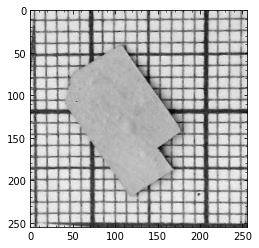

In [37]:
filename = choice(list(filter(lambda x: x.split('.')[-1] == 'jpg', os.listdir('dataset_original'))))
image = np.array(image_open(path.join('dataset_original', filename)))
I = align(rgb2gray(image))
plt.imshow(I, cmap='gray')

## Derivada direcional

* $\mathcal{I}(i, j)$: tom de cinza no ponto $(i, j)$ da imagem
* $\nabla_iI(i, j)$: tom de cinza no ponto $(i, j)$ da derivada na direção $\hat{i}$
* $\nabla_jI(i, j)$: tom de cinza no ponto $(i, j)$ da derivada na direção $\hat{j}$
* $\mathcal{F}$: transformada discreta de fourier

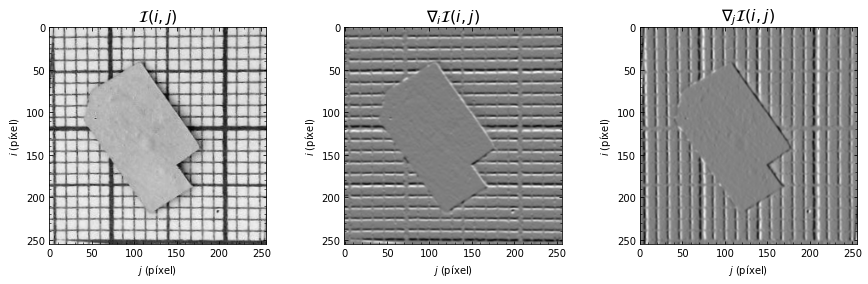

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
#fig.subplots_adjust(wspace=0)
for ax in axs.flat: 
    ax.set_xlabel(r'$j$ (píxel)')
    ax.set_ylabel(r'$i$ (píxel)')

D_j = filters.farid_v(I)
D_i = filters.farid_h(I)

axs[0].imshow(I, cmap='gray')
axs[1].imshow(D_i, cmap='gray')
axs[2].imshow(D_j, cmap='gray')

axs[0].set_title(r'$\mathcal{I}(i, j)$', size=16)
axs[1].set_title(r'$\nabla_i\mathcal{I}(i, j)$', size=16)
axs[2].set_title(r'$\nabla_j\mathcal{I}(i, j)$', size=16)
plt.show()

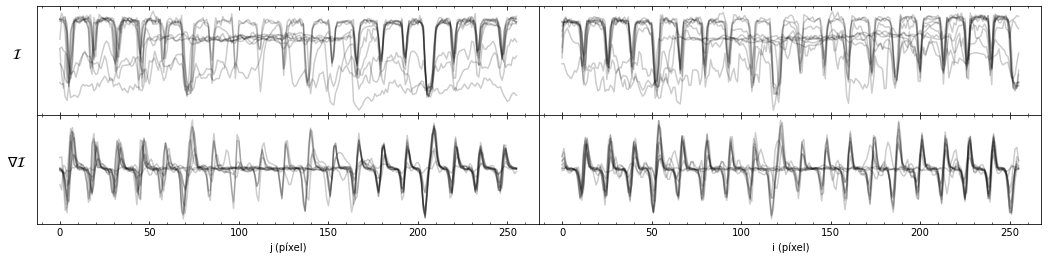

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(18, 4))
fig.subplots_adjust(hspace=0, wspace=0)
for ax in axs.flat: ax.set_yticks([])

for i in np.random.randint(0, len(img), 10):
    axs[0][0].plot(I[i], 'k-', alpha=0.2)
    axs[0][1].plot(I.T[i], 'k-', alpha=0.2)
    axs[1][0].plot(D_i[i], 'k-', alpha=0.2)
    axs[1][1].plot(D_j.T[i], 'k-', alpha=0.2)
    
axs[0][0].set_ylabel(r'$\mathcal{I}$', size=14, rotation=0, labelpad=20)
axs[1][0].set_xlabel(r'j (píxel)')
axs[1][1].set_xlabel(r'i (píxel)')
axs[1][0].set_ylabel(r'$\nabla\mathcal{I}$', size=14, rotation=0, labelpad=20)

plt.show()

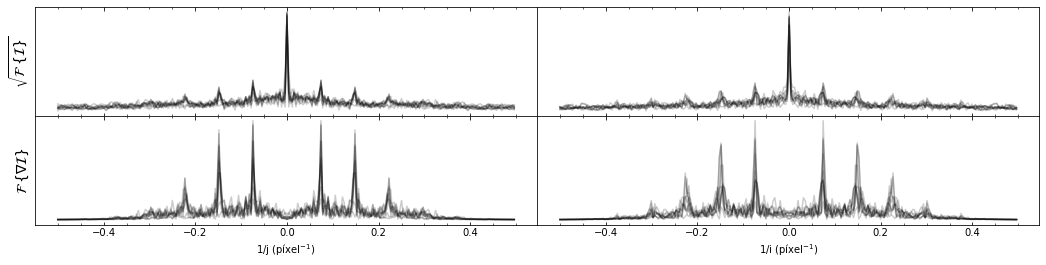

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(18, 4))
fig.subplots_adjust(hspace=0, wspace=0)
for ax in axs.flat: ax.set_yticks([])

freq = np.fft.fftshift(np.fft.fftfreq(256, 1))
fourier = lambda x:np.abs(np.fft.fftshift(np.fft.fft(x)))

for i in np.random.randint(0, len(img), 10):
    axs[0][0].plot(freq, fourier(I[i])**0.5, 'k-', alpha=0.2)
    axs[0][1].plot(freq, fourier(I.T[i])**0.5, 'k-', alpha=0.2)
    axs[1][0].plot(freq, fourier(D_i[i]), 'k-', alpha=0.2)
    axs[1][1].plot(freq, fourier(D_j.T[i]), 'k-', alpha=0.2)
    
axs[1][0].set_xlabel(r'1/j (píxel$^{-1}$)')
axs[1][1].set_xlabel(r'1/i (píxel$^{-1}$)')
axs[0][0].set_ylabel(r'$\sqrt{\mathcal{F}\,\{\mathcal{I}\}}$', size=14)
axs[1][0].set_ylabel(r'$\mathcal{F}\,\{\nabla\mathcal{I}\}$', size=14)
plt.show()

## Autocorrelação

$$C_{xy}(\tau) = \sum_{t = -N}^N x(t)y(t + \tau)$$

$$
\begin{align}
    C_i(\tau, j) = \sum_{t = -N}^N \nabla_iI(t, j)\cdot\nabla_iI(t + \tau, j) &&
    C_j(\tau, i) = \sum_{t = -N}^N \nabla_jI(i, \tau)\cdot\nabla_jI(i, t + \tau)
\end{align}
$$

In [64]:
def autocorr(x, mode='full'):
    return np.correlate(x, x, mode=mode)

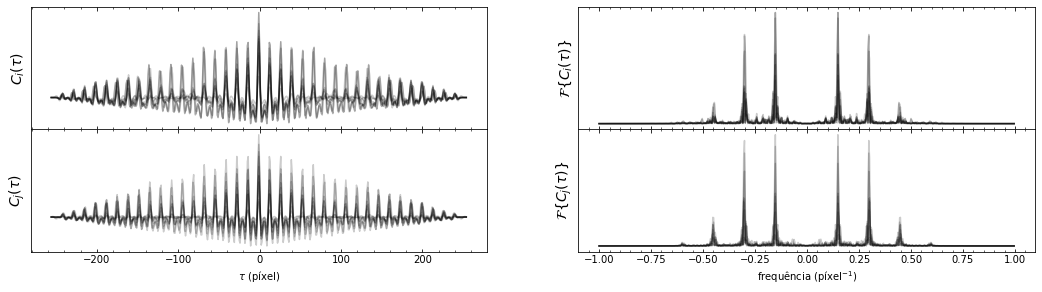

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(18, 4.5))
fig.subplots_adjust(hspace=0)
for ax in axs.flat: ax.set_yticks([])

freq = np.fft.fftshift(np.fft.fftfreq(256*2, 0.5)[:-1])

tau = np.arange(-256, 255)
for i in np.random.randint(0, len(img), 10):
    Ci = autocorr(D_i[i])
    Cj = autocorr(D_j.T[i])
    axs[0][0].plot(tau, Ci, 'k-', alpha=0.2)
    axs[1][0].plot(tau, Cj, 'k-', alpha=0.2)
    axs[0][1].plot(freq, fourier(Ci), 'k-', alpha=0.2)
    axs[1][1].plot(freq, fourier(Cj), 'k-', alpha=0.2)

axs[1][0].set_xlabel(r'$\tau$ (píxel)')
axs[1][1].set_xlabel(r'frequência (píxel$^{-1}$)')

axs[0][0].set_ylabel(r'$C_i(\tau)$', size=14)
axs[1][0].set_ylabel(r'$C_j(\tau)$', size=14)
axs[0][1].set_ylabel(r'$\mathcal{F}\{C_i(\tau)\}$', size=14)
axs[1][1].set_ylabel(r'$\mathcal{F}\{C_j(\tau)\}$', size=14)

plt.show()

## Determinação da escala via PSD

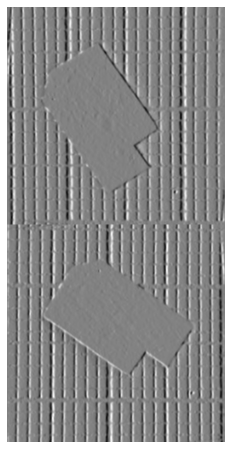

In [85]:
plt.figure(figsize=(4, 8))
far = np.concatenate([D_i, D_j.T])
plt.imshow(far, cmap='gray')
plt.axis('off')
plt.show()

[0.07421875 0.1484375 ]


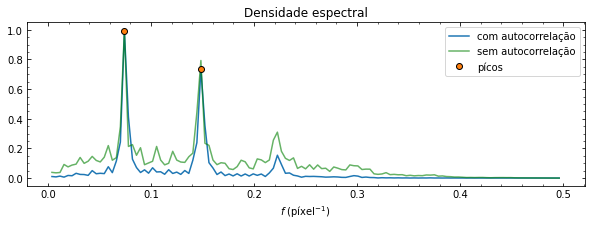

In [105]:
fig, ax = plt.subplots(figsize=(10, 3))

freq = np.fft.fftfreq(256, 1)
loc = (freq > 0)

fft = lambda x: norm(np.abs(np.fft.fft(x))[loc])
auto_fft = lambda x: norm(np.abs(np.fft.fft(autocorr(x, 'same')))[loc])

M = np.random.randint(0, len(img), 20)
Y = np.apply_along_axis(auto_fft, 0, far[M].T).mean(axis=1)

ax.plot(freq[loc], Y, label='com autocorrelação')
ax.plot(freq[loc], np.apply_along_axis(fft, 0, far[M].T).mean(axis=1), 'g-', alpha=0.6, label='sem autocorrelação')

P = find_peaks(Y, prominence=0.5)[0]
F = freq[loc][P]
ax.plot(F, Y[P], 'o', label='pícos')
ax.legend()
ax.set_xlabel(r'$f$ (píxel$^{-1}$)')
ax.set_title('Densidade espectral')

print(F)

plt.show()

# Testes

In [106]:
def find_scale(img, N=20):
    L = len(img)
    freq = np.fft.fftfreq(L, 1)
    loc = (freq > 0)
    auto_fft = lambda x: norm(np.abs(np.fft.fft(autocorr(x, 'same')))[loc])
    far = np.concatenate([filters.farid_v(img), filters.farid_h(img).T])
    Y = np.apply_along_axis(auto_fft, 0, far[np.random.randint(0, L, N)].T).mean(axis=1)
    P = find_peaks(Y, height=0.5)[0]
    return freq[loc][P].min()

def get(filename, root=''):
    return np.array(image_open(path.join(root, filename)))

In [107]:
imgs = {'area':[], 'pixel_area':[], 'scale':[]}
for filename in os.listdir('dataset_original'):
    *a, ext = filename.split('.')
    if ext == 'tif':
        area = float('.'.join(a))
        imgs['area'].append(area)
        imgs['pixel_area'].append(np.sum(get(filename, 'dataset_original')/255))
        imgs['scale'].append(find_scale(rgb2gray(get('.'.join((*a, 'jpg')), 'dataset_original'))))
imgs = pd.DataFrame(imgs)
imgs.head()

,area,pixel_area,scale
0,100.473,21589.0,0.066406
1,101.217,15300.0,0.082031
2,104.478,17007.0,0.078125
3,107.840,15042.0,0.085938
4,109.973,16508.0,0.082031


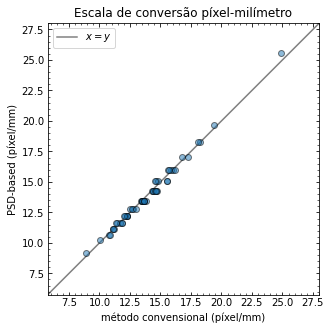

In [113]:
_, ax = plt.subplots(figsize=(5, 5))

x = np.sqrt(imgs.pixel_area/imgs.area).values
y = 1/imgs.scale
plt.plot(x, y, 'o', zorder=1, alpha=0.5)

t = np.linspace(x.min()-x.ptp()*0.25, x.max()+x.ptp()*0.25)
plt.plot(t, t, c='k', label=r'$x=y$', zorder=0, alpha=0.5)

plt.xlabel('método convensional (píxel/mm)')
plt.ylabel('PSD-based (píxel/mm)')
ax.set_aspect('equal')
plt.legend()
plt.xlim(x.min()-x.ptp()*0.2, x.max()+x.ptp()*0.2)
plt.ylim(x.min()-x.ptp()*0.2, x.max()+x.ptp()*0.2)
plt.title('Escala de conversão píxel-milímetro')

plt.show()

In [114]:
(np.abs(x-y)/y*100).describe()

count    54.000000
mean      1.419770
std       0.979978
min       0.028074
25%       0.578901
50%       1.228907
75%       2.043691
max       3.519313
Name: scale, dtype: float64

# Referência

* Signal Processing and Machine Learning with Applications